# Enrich Example

As in Part 1, we are looking at the example of a large retailer evaluating potential sites for a new location. This retailer is interested in using key criteria they know are important based on previous experience to evaluate a few candidates. These criteria include competition, traffic, economic feasibility and market potential for the areas surrounding the potential sites. Utilizing the GeoEnrichment module, the real estate site selection team can include demographic variables such as lifestyle, income, spending and education to understand potential customers in the study areas surrounding the candidate sites.

Although we will go a similar route, in this example all we have to start with are addresses.

In [10]:
from arcgis.geoenrichment import Country, enrich
from arcgis.gis import GIS

gis = GIS(profile="your_online_profile")

In [2]:
country = Country("usa", gis=gis)
country

<Country - United States (GIS @ https://geosaurus.maps.arcgis.com version:10.3)>

In [3]:
import pandas as pd

candidate_df = pd.read_csv("../data/health.csv").loc[
    :, ["Name", "Address", "City", "State", "Zip Code"]
]

candidate_df

,Name,Address,City,State,Zip Code
0,Facility 1,2468 SOUTH ST ANDREWS PLACE,LOS ANGELES,CA,90018
1,Facility 2,2300 W. WASHINGTON BLVD.,LOS ANGELES,CA,90018
2,Facility 3,4060 E. WHITTIER BLVD.,LOS ANGELES,CA,90023
3,Facility 4,6070 W. PICO BOULEVARD,LOS ANGELES,CA,90035
4,Facility 5,1480 S. LA CIENEGA BL,LOS ANGELES,CA,90035


Next, we are going to concatenate the address into one column and rename the `Name` column to `loc_id` to match more closely with the example from the GeoEnrichment Part 1 notebook.

In [4]:
# create full address string to make geocoding easier
candidate_df["full_address"] = candidate_df.apply(
    lambda r: ", ".join((r["Address"], r["City"], r["State"])) + f' {r["Zip Code"]}',
    axis=1,
)

# filter columns
candidate_df = candidate_df.loc[:, ["Name", "full_address"]].rename(
    columns={"Name": "loc_id"}
)

candidate_df

,loc_id,full_address
0,Facility 1,"2468 SOUTH ST ANDREWS PLACE, LOS ANGELES, CA 9..."
1,Facility 2,"2300 W. WASHINGTON BLVD., LOS ANGELES, CA 90018"
2,Facility 3,"4060 E. WHITTIER BLVD., LOS ANGELES, CA 90023"
3,Facility 4,"6070 W. PICO BOULEVARD, LOS ANGELES, CA 90035"
4,Facility 5,"1480 S. LA CIENEGA BL, LOS ANGELES, CA 90035"


## Enrich Variables

We are going to use the same variables for enrichment as in Part 1.

In [5]:
analysis_variables = [
    "TOTPOP_CY",  # Population: Total Population (Esri)
    "DIVINDX_CY",  # Diversity Index (Esri)
    "AVGHHSZ_CY",  # Average Household Size (Esri)
    "MEDAGE_CY",  # Age: Median Age (Esri)
    "MEDHINC_CY",  # Income: Median Household Income (Esri)
    "BACHDEG_CY",  # Education: Bachelor's Degree (Esri)
]

analysis_variables

['TOTPOP_CY',
 'DIVINDX_CY',
 'AVGHHSZ_CY',
 'MEDAGE_CY',
 'MEDHINC_CY',
 'BACHDEG_CY']

### Define Study Areas

The enrich capability in Business Analyst requires polygon areas to be used for [apportioning demographic data](https://developers.arcgis.com/rest/GeoEnrichment/api-reference/data-apportionment.htm) to the input geographies. In this case, they are addresses defining store locations. Geocoding can be used to get the location of the stores, but the `enrich` method still requires areas to be able to apportion demographic data.

First, we can use geocoding to get the geographic location of all the stores. Since we are using a Pandas DataFrame, we can take advantage of data manipulation and schema pruning. Firstly, to concatenate the components of the addresss into a concise column for geocoding. Secondly, by reducing the geocoding response to just columns we need for subsequent analysis steps.

In [6]:
from arcgis.features import GeoAccessor
from arcgis.geocoding import get_geocoders

# ensure using intended geocoder
agol_geocoder = get_geocoders(gis)[0]

# geocode the addresses and prune the retunred columns
geocode_df = GeoAccessor.from_df(
    candidate_df, address_column="full_address", geocoder=agol_geocoder
).loc[:, ["loc_id", "full_address", "SHAPE"]]

# following pruning schema, re-enable spatial
geocode_df.spatial.set_geometry("SHAPE")
assert geocode_df.spatial.validate()

geocode_df

,loc_id,full_address,SHAPE
0,Facility 1,"2468 SOUTH ST ANDREWS PLACE, LOS ANGELES, CA 9...","{""x"": -118.31127251419741, ""y"": 34.03313999252..."
1,Facility 2,"2300 W. WASHINGTON BLVD., LOS ANGELES, CA 90018","{""x"": -118.31183535899584, ""y"": 34.03988893331..."
2,Facility 3,"4060 E. WHITTIER BLVD., LOS ANGELES, CA 90023","{""x"": -118.1843180294075, ""y"": 34.023902464669..."
3,Facility 4,"6070 W. PICO BOULEVARD, LOS ANGELES, CA 90035","{""x"": -118.37276542483494, ""y"": 34.05264979417..."
4,Facility 5,"1480 S. LA CIENEGA BL, LOS ANGELES, CA 90035","{""x"": -118.37613251915946, ""y"": 34.05099298527..."


As in the example from the first Notebook, **study areas** can be polygons defined manually beforehand and provided as input. They can also be standard geographic areas defined with the unique identifiers for the areas, such as postal (ZIP) codes. Finally, as is the case with our example, study areas can be provided as lines or points. Since lines and points do not define an area, in these cases, polygons are created on the server to use for apportioning data to each location.

The polygons created around lines and points, by default, is a five kilometer straight-line buffered area. This can be controlled using the `proximity` parameters of the enrich method; `proximity_type`, `proximity_value` and `proximity_metric`. For line geometries, only the straight line method can be used, but for point geometries, any transportation network method available in the GIS can be used to define the area surrounding the points, thus delineating the study areas to be used.

#### Discover Available Travel Modes

In the example we know customers will travel about eight minutes to visit the store locations. The enrich method is capable of creating eight-minute drive time areas around the stores for us, but we need to know how to provide the correct inputs. We can discover available travel modes using the `travel_modes` property.

In [7]:
country.travel_modes

,name,alias,description,type,impedance,impedance_category,time_attribute_name,distance_attribute_name,travel_mode_id,travel_mode_dict
0,driving_time,Driving Time,Models the movement of cars and other similar ...,AUTOMOBILE,TravelTime,temporal,TravelTime,Kilometers,FEgifRtFndKNcJMJ,"{""attributeParameterValues"": [{""attributeName""..."
1,driving_distance,Driving Distance,Models the movement of cars and other similar ...,AUTOMOBILE,Kilometers,distance,TravelTime,Kilometers,iKjmHuBSIqdEfOVr,"{""attributeParameterValues"": [{""attributeName""..."
2,trucking_time,Trucking Time,Models basic truck travel by preferring design...,TRUCK,TruckTravelTime,temporal,TruckTravelTime,Kilometers,ZzzRtYcPLjXFBKwr,"{""attributeParameterValues"": [{""attributeName""..."
3,trucking_distance,Trucking Distance,Models basic truck travel by preferring design...,TRUCK,Kilometers,distance,TruckTravelTime,Kilometers,UBaNfFWeKcrRVYIo,"{""attributeParameterValues"": [{""attributeName""..."
4,walking_time,Walking Time,Follows paths and roads that allow pedestrian ...,WALK,WalkTime,temporal,WalkTime,Kilometers,caFAgoThrvUpkFBW,"{""attributeParameterValues"": [{""attributeName""..."
5,walking_distance,Walking Distance,Follows paths and roads that allow pedestrian ...,WALK,Kilometers,distance,WalkTime,Kilometers,yFuMFwIYblqKEefX,"{""attributeParameterValues"": [{""attributeName""..."
6,rural_driving_time,Rural Driving Time,Models the movement of cars and other similar ...,AUTOMOBILE,TravelTime,temporal,TravelTime,Kilometers,NmNhNDUwZmE1YTlj,"{""attributeParameterValues"": [{""attributeName""..."
7,rural_driving_distance,Rural Driving Distance,Models the movement of cars and other similar ...,AUTOMOBILE,Kilometers,distance,TravelTime,Kilometers,Yzk3NjI1NTU5NjVj,"{""attributeParameterValues"": [{""attributeName""..."


Any value from the `name` column can be used direclty as input to the enrich method to define the study area `proximity_type`. For this example, to define eight minute drive times, we can populate the proximity factors accordingly.

In [13]:
enrich_df = country.enrich(
    geocode_df,
    enrich_variables=analysis_variables,
    proximity_type="driving_time",
    proximity_value=8,
    proximity_metric="minutes",
)


enrich_df

,loc_id,full_address,source_country,area_type,buffer_units,buffer_units_alias,buffer_radii,aggregation_method,population_to_polygon_size_rating,apportionment_confidence,has_data,medage_cy,totpop_cy,avghhsz_cy,bachdeg_cy,medhinc_cy,divindx_cy,SHAPE
0,Facility 1,"2468 SOUTH ST ANDREWS PLACE, LOS ANGELES, CA 9...",USA,NetworkServiceArea,Minutes,Drive Time Minutes,8.0,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,32.8,276718.0,2.81,33723.0,48083.0,87.8,"{""rings"": [[[-118.31409427984764, 34.064380416..."
1,Facility 2,"2300 W. WASHINGTON BLVD., LOS ANGELES, CA 90018",USA,NetworkServiceArea,Minutes,Drive Time Minutes,8.0,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,33.7,305454.0,2.68,43130.0,50213.0,88.1,"{""rings"": [[[-118.31409427984764, 34.072465217..."
2,Facility 3,"4060 E. WHITTIER BLVD., LOS ANGELES, CA 90023",USA,NetworkServiceArea,Minutes,Drive Time Minutes,8.0,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,30.5,170309.0,3.62,9400.0,52719.0,65.7,"{""rings"": [[[-118.16227969122916, 34.070668594..."
3,Facility 4,"6070 W. PICO BOULEVARD, LOS ANGELES, CA 90035",USA,NetworkServiceArea,Minutes,Drive Time Minutes,8.0,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,38.5,201739.0,2.21,54857.0,96918.0,80.4,"{""rings"": [[[-118.36597175035031, 34.088185662..."
4,Facility 5,"1480 S. LA CIENEGA BL, LOS ANGELES, CA 90035",USA,NetworkServiceArea,Minutes,Drive Time Minutes,8.0,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,38.6,198064.0,2.18,54132.0,97074.0,79.6,"{""rings"": [[[-118.37652690642967, 34.088185662..."


The response includes metadata related to how the enrichment was performed. However, if we are only interested in the demographic columns added, we can filter using the available enrich variable names.

In [9]:
# get just the enrich columns
enrich_cols = [
    c for c in enrich_df if c in country.enrich_variables.name.str.lower().values
]

# combine the enrich columns with a few others we want to keep
keep_cols = ["loc_id"] + enrich_cols + ["SHAPE"]

# filter the enrich data frame to just these columns
enrich_df = enrich_df.loc[:, keep_cols].set_index("loc_id")

# re-enable spatial awareness
enrich_df.spatial.set_geometry("SHAPE")

enrich_df

,medage_cy,totpop_cy,avghhsz_cy,bachdeg_cy,medhinc_cy,divindx_cy,SHAPE
loc_id,,,,,,,
Facility 1,32.8,276718.0,2.81,33723.0,48083.0,87.8,"{""rings"": [[[-118.31409427984764, 34.064380416..."
Facility 2,33.7,305454.0,2.68,43130.0,50213.0,88.1,"{""rings"": [[[-118.31409427984764, 34.072465217..."
Facility 3,30.5,170309.0,3.62,9400.0,52719.0,65.7,"{""rings"": [[[-118.16227969122916, 34.070668594..."
Facility 4,38.5,201739.0,2.21,54857.0,96918.0,80.4,"{""rings"": [[[-118.36597175035031, 34.088185662..."
Facility 5,38.6,198064.0,2.18,54132.0,97074.0,79.6,"{""rings"": [[[-118.37652690642967, 34.088185662..."


## Evaluate Results

An extremely effective starting point for analysis is visualizing the results. Here, we are using `matplotlib` to visualize the differences between the locations based on the enriched data.

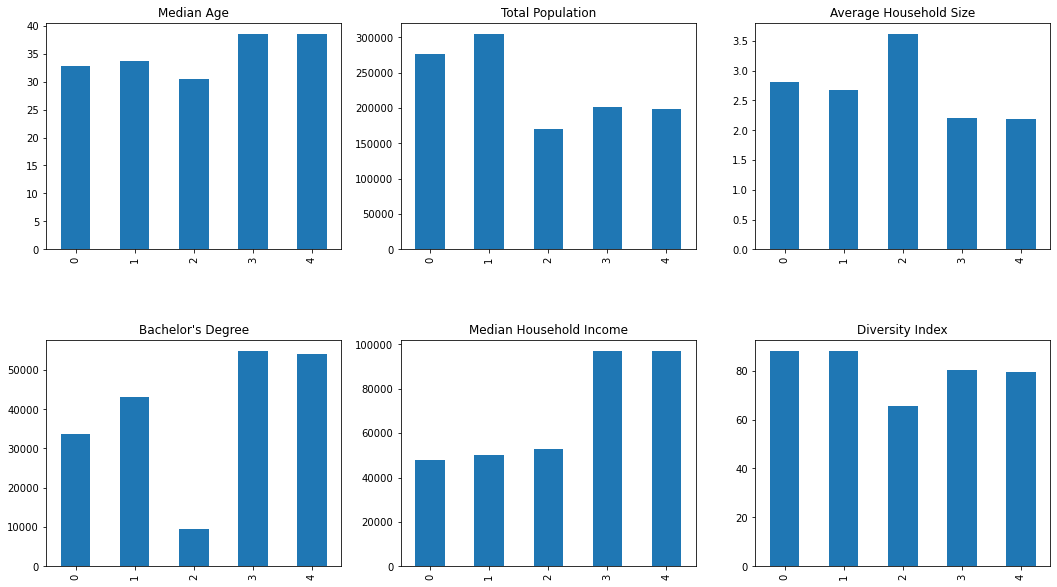

In [14]:
# this is due to a deprication warning inside matplotlib
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 3)
fig.set_figheight(10.0)
fig.set_figwidth(18.0)
fig.subplots_adjust(hspace=0.4)

plt.sca(axs[0, 0])
_ = enrich_df.medage_cy.plot(title="Median Age", kind="bar")

plt.sca(axs[0, 1])
_ = enrich_df.totpop_cy.plot(title="Total Population", kind="bar")

plt.sca(axs[0, 2])
_ = enrich_df.avghhsz_cy.plot(title="Average Household Size", kind="bar")

plt.sca(axs[1, 0])
_ = enrich_df.bachdeg_cy.plot(title="Bachelor's Degree", kind="bar")

plt.sca(axs[1, 1])
_ = enrich_df.medhinc_cy.plot(title="Median Household Income", kind="bar")

plt.sca(axs[1, 2])
_ = enrich_df.divindx_cy.plot(title="Diversity Index", kind="bar")

As in Part 1:  
Facility 1 and facility 2 have higher populations, and are diverse with less income. Facility 3 is far younger with larger households, less education, and have lower incomes. Facility 4 and facility 5 are older, more educated and have a higher income.

If interested in opening a discount department store, facility 2 is the most attractive location with facility 1 as a close second. The diversity and lower income can allow us to conclude that people will buy at lower prices.

If interested in opening a quick service restaurant, facility 3 may be the best option to meet the needs of a young, busy and price conscious population.

Obviously, depending on the key characteristics of the business looking for a new location, the key demographic indicators will be different. Using geoenrichment, paired with the ArcGIS API for Python, enables extremely quick access to demographic variables for informed decision making.